In [109]:
import torch # pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, os, json, gc, math
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils.Network.index import ModelNetwork
from utils.Files import *

In [110]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

gc.collect()
print(torch.__version__)              # versão do PyTorch
print(torch.cuda.is_available())      # True se detectou a GPU
print(torch.cuda.get_device_name(0))  # nome da GPU
pd.set_option('display.max_columns', None)

2.7.1+cu118
True
Quadro P6000


# HISTÓRICO DE TREINAMENTO

In [111]:
df = []

for bakup in os.listdir('backup/'):
    path = f'backup/{bakup}/info.json'

    with open(path, 'r', encoding='utf-8') as file:
        info = json.loads(file.read())
    
    df.append(info)


df = pd.DataFrame(df).sort_values(by='criterion')
df

,dataset,tile_size,img_size,n_aug,n_images,multiclass,model_network,model_channels,timestamp,classes,batch_size,criterion,val_iou,test_iou
3,dataset1,0,128,0,595,True,resaceunet,1,10/02/26 07:56:18,6,4,cross_entropy,0.049266,0.096681
1,dataset1,0,128,0,595,True,segresnet,1,11/02/26 14:31:59,6,4,dice,0.696387,0.732262
8,dataset1,0,128,0,595,True,resaceunet,1,10/02/26 11:01:46,6,4,diceCE,0.054998,0.075900
0,dataset1,0,128,0,595,True,segresnet,1,10/02/26 20:02:44,6,4,dice_focal,0.702847,0.778480
4,dataset1,0,128,0,595,True,standard,1,07/02/26 10:49:40,6,2,dice_focal,0.330545,0.431063
5,dataset1,0,128,0,595,True,segresnet,1,09/02/26 14:04:52,6,4,dice_focal,0.663157,0.763581
6,dataset1,0,128,0,595,True,resaceunet,1,09/02/26 18:26:46,6,4,dice_focal,0.358400,0.411653
7,dataset1,0,128,0,595,True,monai_unet,1,08/02/26 22:54:32,6,2,dice_focal,0.556805,0.606408
2,dataset1,0,128,0,595,True,resaceunet,1,10/02/26 14:10:42,6,4,focal,0.054998,0.075900


summary:  mean


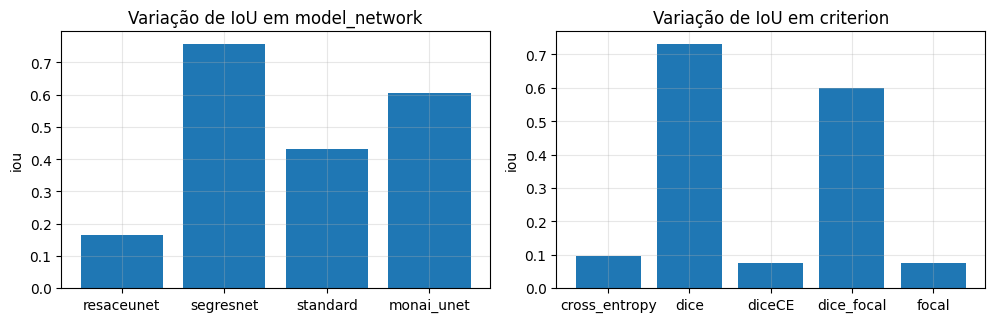

summary:  max


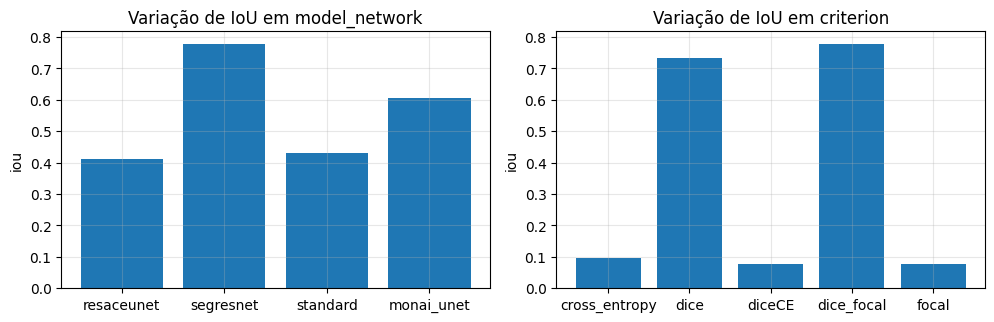

summary:  std


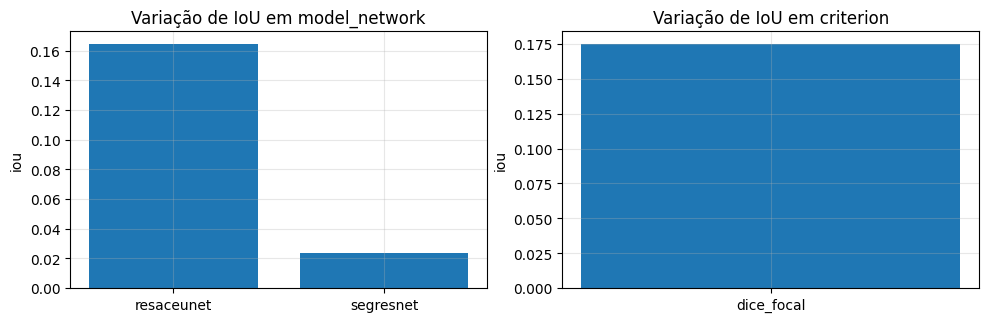

In [112]:
def plotSummary(metric):
    columns = ['model_network', 'criterion']
    size    = len(df)
    numCols = 3 if size >= 3 else size
    numRows = math.ceil(size / numCols)
    plt.figure(figsize=(5*numCols, 3*numRows))

    print('summary: ', metric)
    i = 1
    for variable in columns:
        data = {}

        for value in df[variable].unique():
            iou = df.loc[df[variable] == value].test_iou.agg(metric)
            data[value] = iou
        
        plt.subplot(numRows, numCols, i)
        plt.bar(data.keys(), data.values())
        plt.ylabel('iou'); plt.title(f'Variação de IoU em {variable}')
        plt.grid(alpha=0.3)
        i = (i + 1)

    plt.tight_layout()
    plt.show()


plotSummary('mean')
plotSummary('max')
plotSummary('std')

# IMPORTANDO DADOS

In [113]:
import torch.nn.functional as F
from torch import amp
from utils.Network.index import ModelNetwork

model 9 loaded, trained in 11/02/26 14:31:59
{
    "dataset": "dataset1",
    "tile_size": 0,
    "img_size": 128,
    "n_aug": 0,
    "n_images": 595,
    "multiclass": true,
    "model_network": "segresnet",
    "model_channels": 1,
    "timestamp": "11/02/26 14:31:59",
    "classes": 6,
    "batch_size": 4,
    "criterion": "dice",
    "val_iou": 0.6963866353034973,
    "test_iou": 0.7322624325752258
}


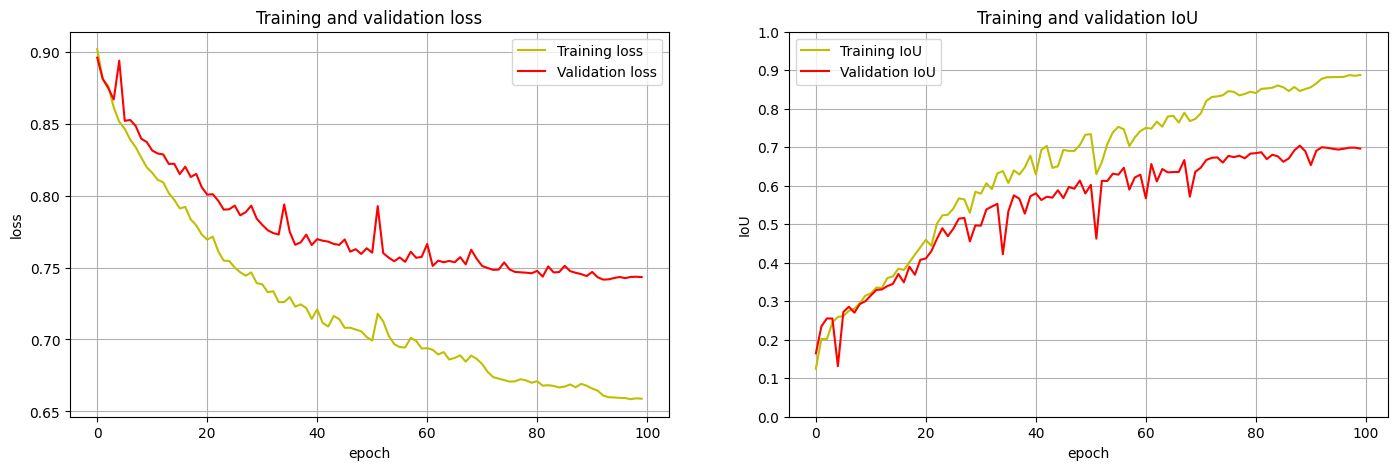

In [ ]:
class Loader:
    def __init__(self, index=-1):
        self.index = index if index > 0 else max([int(path.split('_')[-1]) for path in os.listdir('backup/')])
        self.path  = f'backup/model_{self.index}'

        info = self.getInfo() 
        self.name     = info['model_network']
        self.classes  = info['classes']
        self.img_size = info['img_size']
        self.channels = info['model_channels']
        self.index    = index
        self.info = info

        self.network = ModelNetwork(self.name, self.img_size, self.classes, self.channels)  
        data = torch.load(f'{self.path}/data.pth', map_location=self.network.device)

        self.history   = data['history']
        self.timestamp = data['timestamp']

        self.network.model.load_state_dict(data['model'])
        self.network.optimizer.load_state_dict(data['optimizer'])

        print(f'model {index} loaded, trained in {data["timestamp"]}')
        print(json.dumps(info, indent=4))

    def getInfo(self):
        with open(f'{self.path}/info.json', 'r', encoding='utf-8') as file:
            return json.load(file)

    def plot(self, save=False):
        history = self.history
        plt.figure(figsize=(17, 5))
        plt.subplot(1, 2, 1)
        plt.plot([h.get('train_loss') for h in history], 'y', label='Training loss')
        plt.plot([h.get('val_loss') for h in history], 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('epoch'), plt.ylabel('loss')
        plt.legend(), plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot([h.get('train_iou') for h in history], 'y', label='Training IoU')
        plt.plot([h.get('val_iou')   for h in history], 'r',  label='Validation IoU')
        plt.title('Training and validation IoU')
        plt.xlabel('epoch'), plt.ylabel('IoU')
        plt.legend(), plt.grid(), plt.gca().set_ylim(0, 1), plt.yticks([c/10 for c in range(11)])
        
        if not save:
            return plt.show()

        plt.savefig(f'{self.path}/train.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        plt.close()


loader = Loader(-1)
loader.plot(True)

In [115]:
network = loader.network
network.model

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

# DOWNLOAD DOS DADOS

In [116]:
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics.classification import BinaryJaccardIndex

In [117]:
def getLoader(xData, yData, batch, shuffle=False):
    xTensor = torch.from_numpy(xData).float().unsqueeze(1) 
    yTensor = torch.from_numpy(yData).long() if network.multiclass else torch.from_numpy(yData).float().unsqueeze(1)
    dataset = TensorDataset(xTensor, yTensor)
    return DataLoader(dataset, batch_size=batch, shuffle=shuffle, pin_memory=False)


xTest = np.array([np.load(path) for path in getFiles('database/processed/test/images')])
yTest = np.array([np.load(path)  for path in getFiles('database/processed/test/masks')])
test_loader = getLoader(xTest, yTest, batch=1)

H, W = (loader.img_size, loader.img_size)
test_loader.__len__()

60

In [118]:
network.model.eval()
network.iou.reset()
yModel = []

with torch.no_grad():
    for (imgs, masks) in test_loader:
        imgs, masks = imgs.to(network.device), masks.to(network.device)
        logits = network.model(imgs)
        
        preds  = torch.argmax(logits, dim=1)
        target = masks.squeeze(1) if masks.dim() == 5 else masks
        network.iou.update(preds, target)
        yModel.append(preds.cpu().numpy()[0])
        
test_iou = network.iou.compute().item()
test_iou

0.7322624325752258

{'class_0': 0.9347191452980042, 'class_1': 0.5512603521347046, 'class_2': 0.6040709018707275, 'class_3': 0.6180725693702698, 'class_4': 0.724757969379425, 'class_5': 0.9606934785842896}


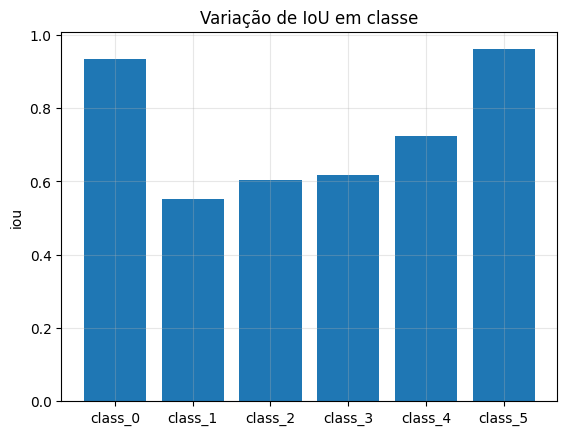

In [119]:
iou = MulticlassJaccardIndex(num_classes=network.classes, average=None).to(network.device)
network.model.eval()
iou.reset()

with torch.no_grad():
    for (imgs, masks) in test_loader:
        imgs, masks = imgs.to(network.device), masks.to(network.device)
        logits = network.model(imgs)
        
        preds  = torch.argmax(logits, dim=1)
        target = masks.squeeze(1) if masks.dim() == 5 else masks
        iou.update(preds, target)


iouData = {f'class_{i}': score.item() for i, score in enumerate(iou.compute())}
print(iouData)

plt.bar(iouData.keys(), iouData.values())
plt.ylabel('iou'); plt.title(f'Variação de IoU em classe')
plt.grid(alpha=0.3)
plt.savefig(f'{loader.path}/iou_classes.png')
plt.show()

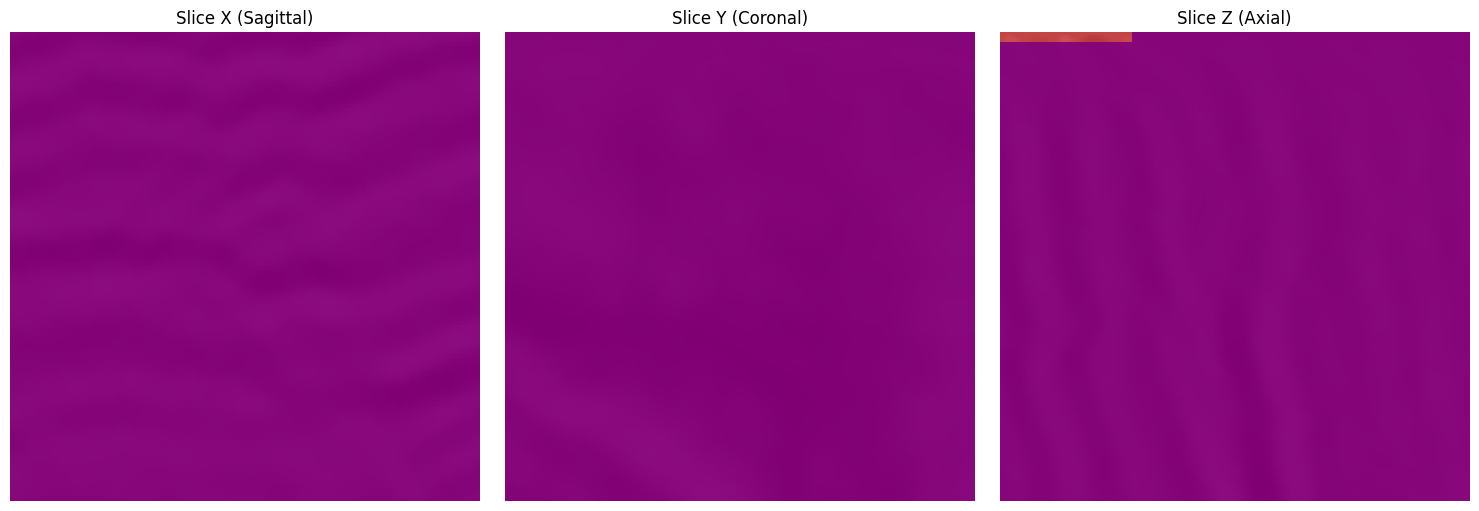

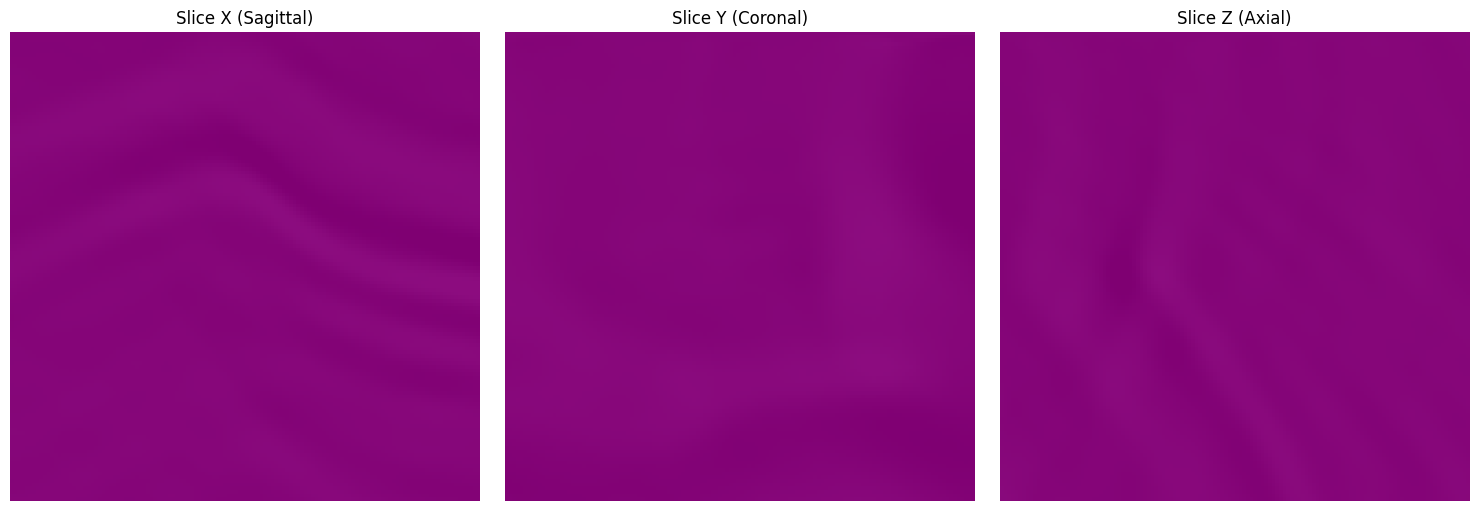

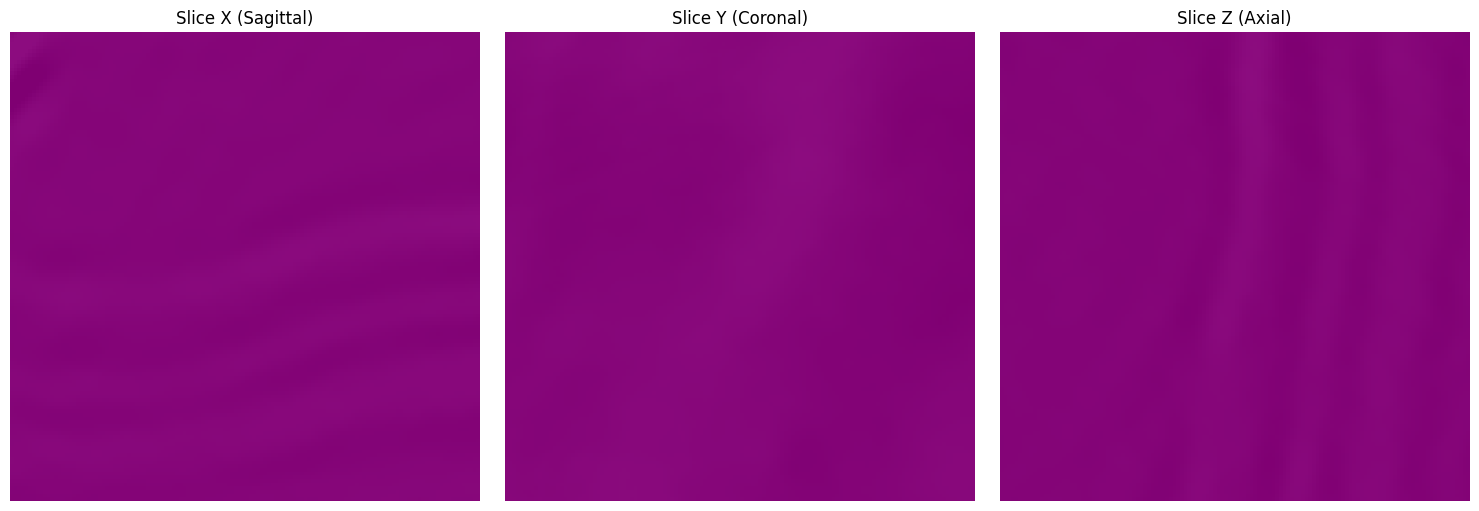

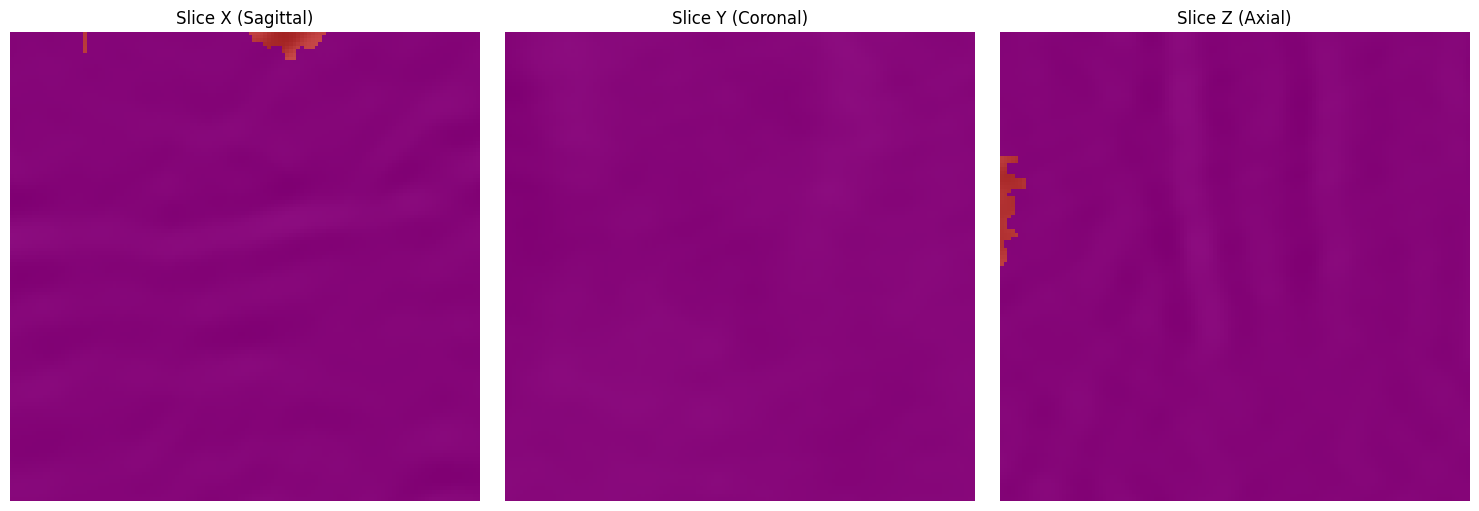

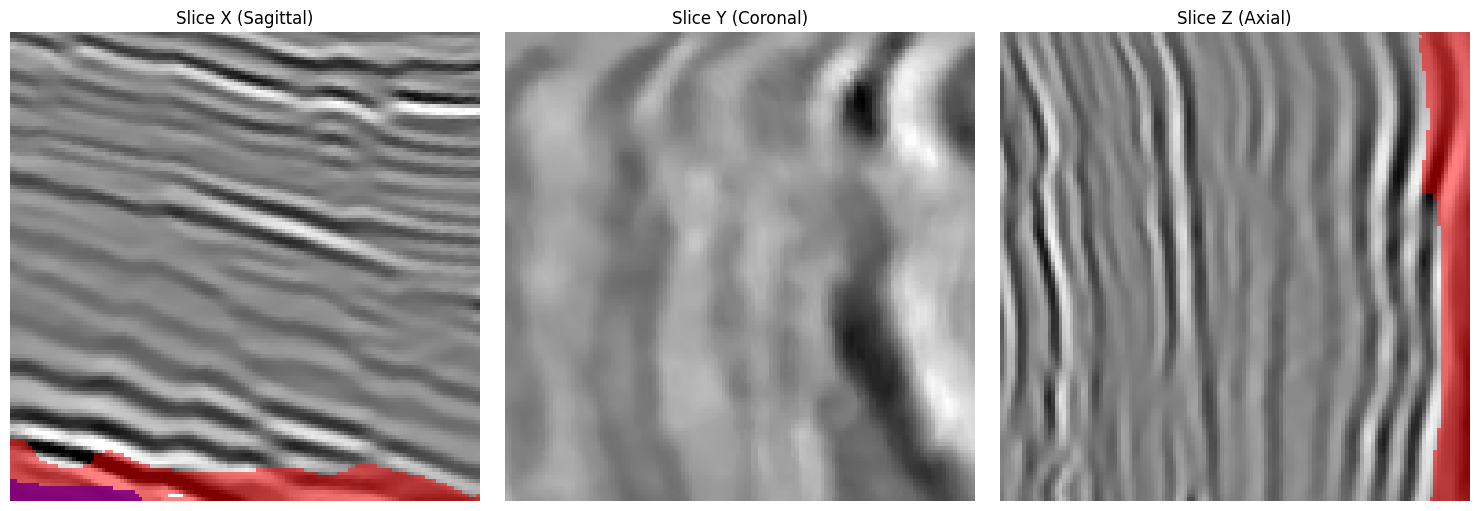

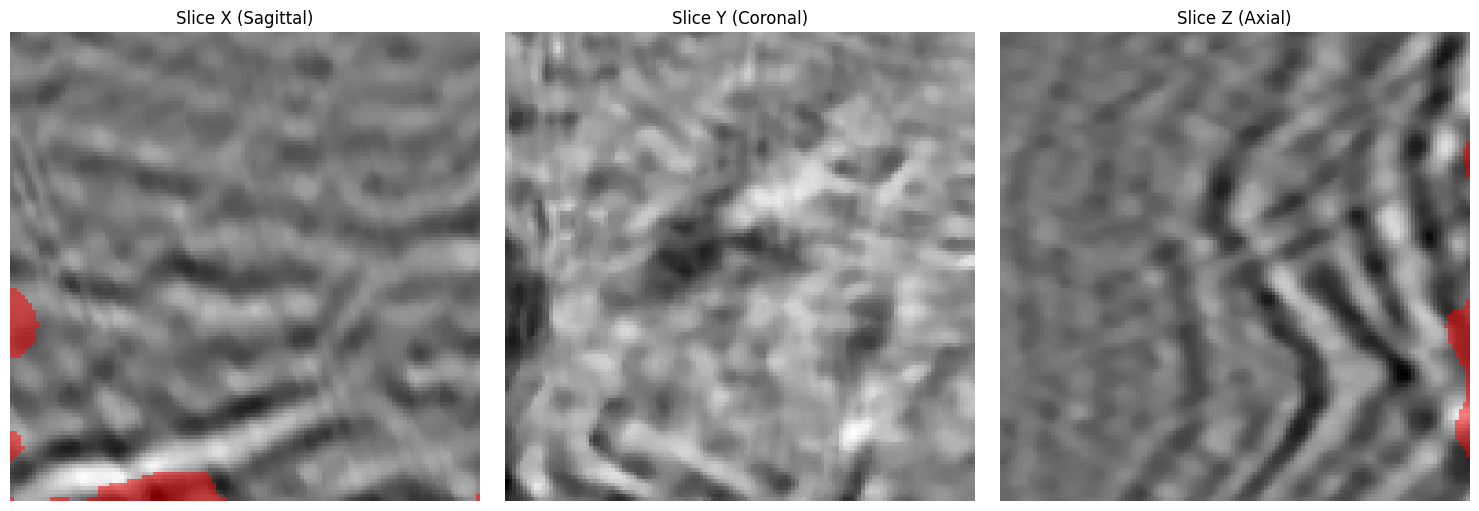

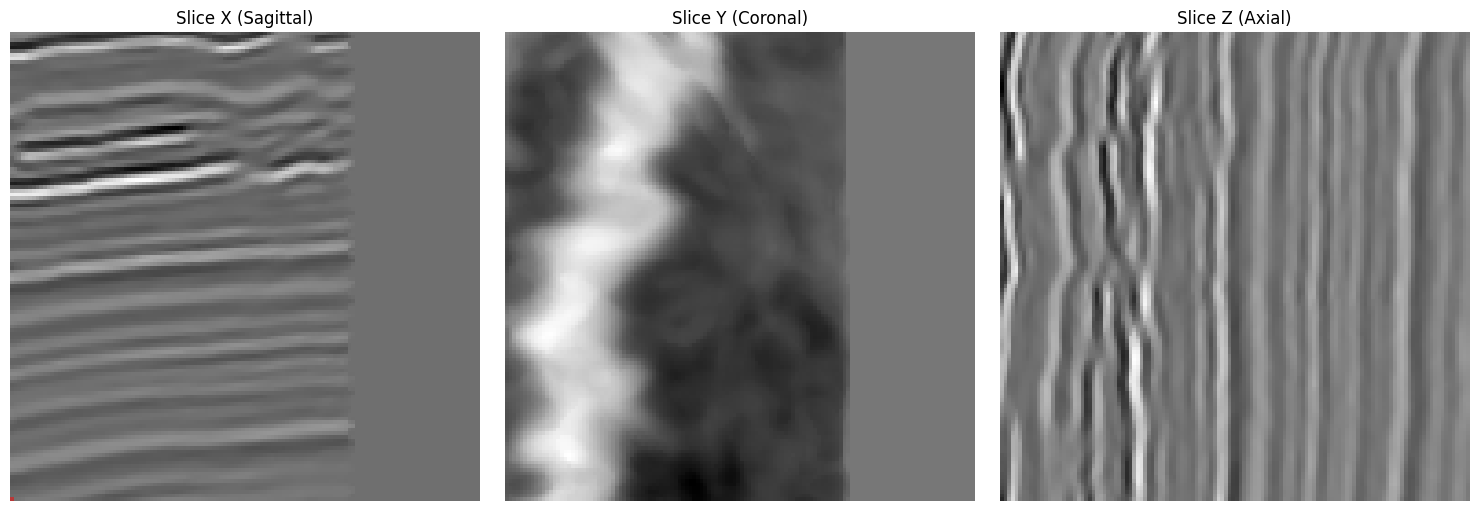

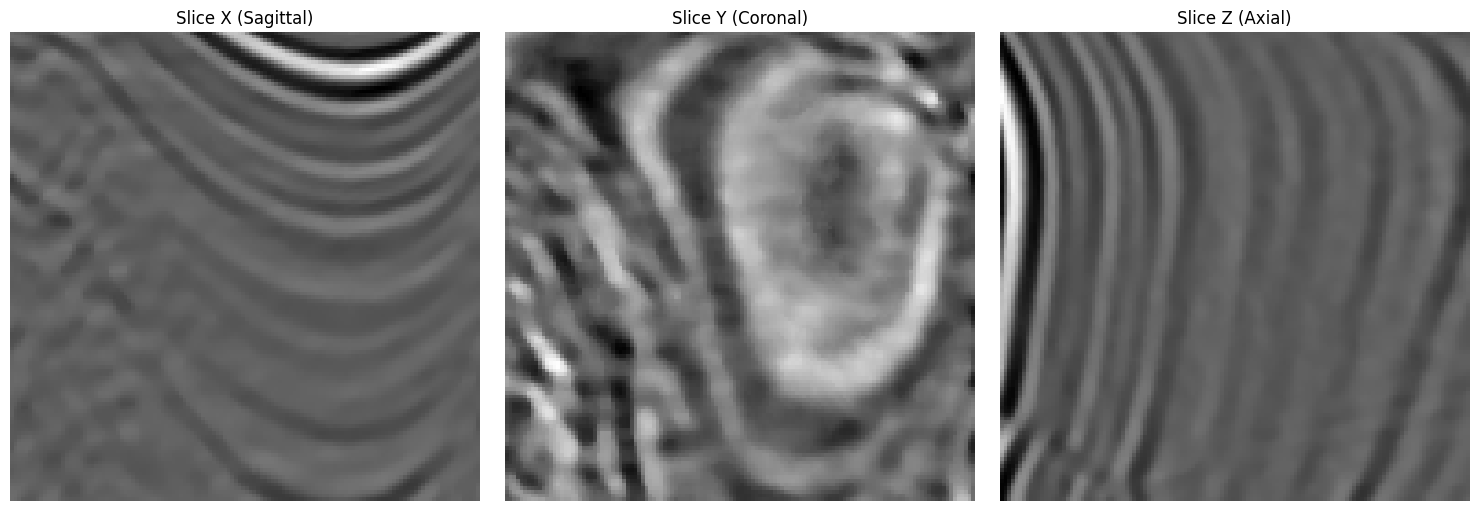

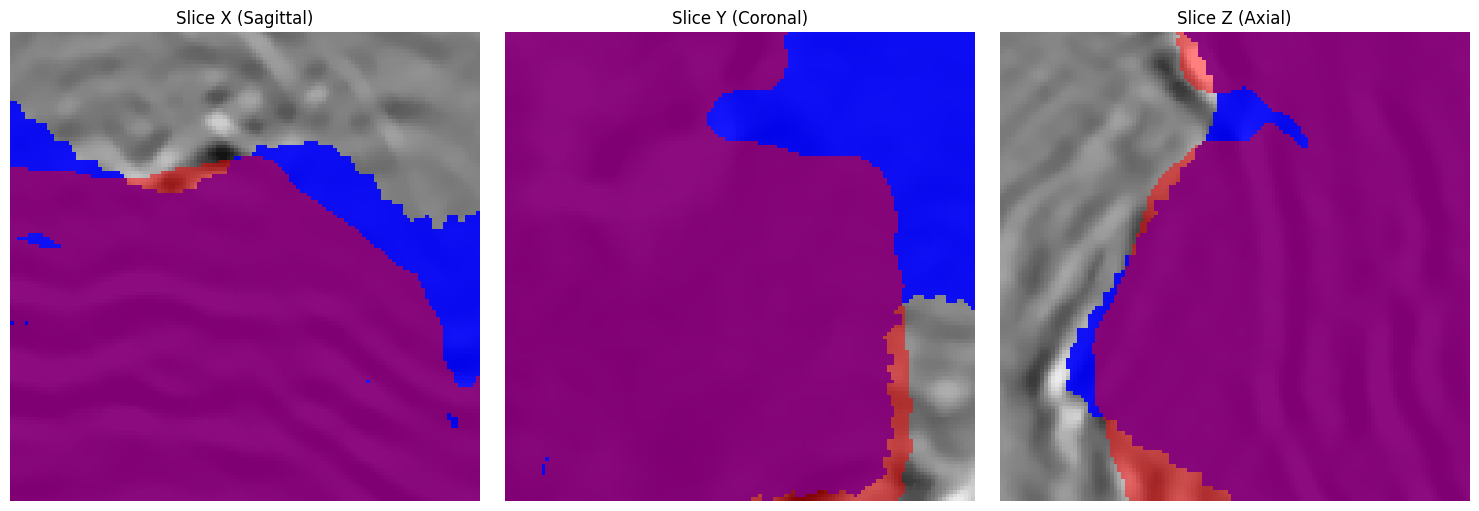

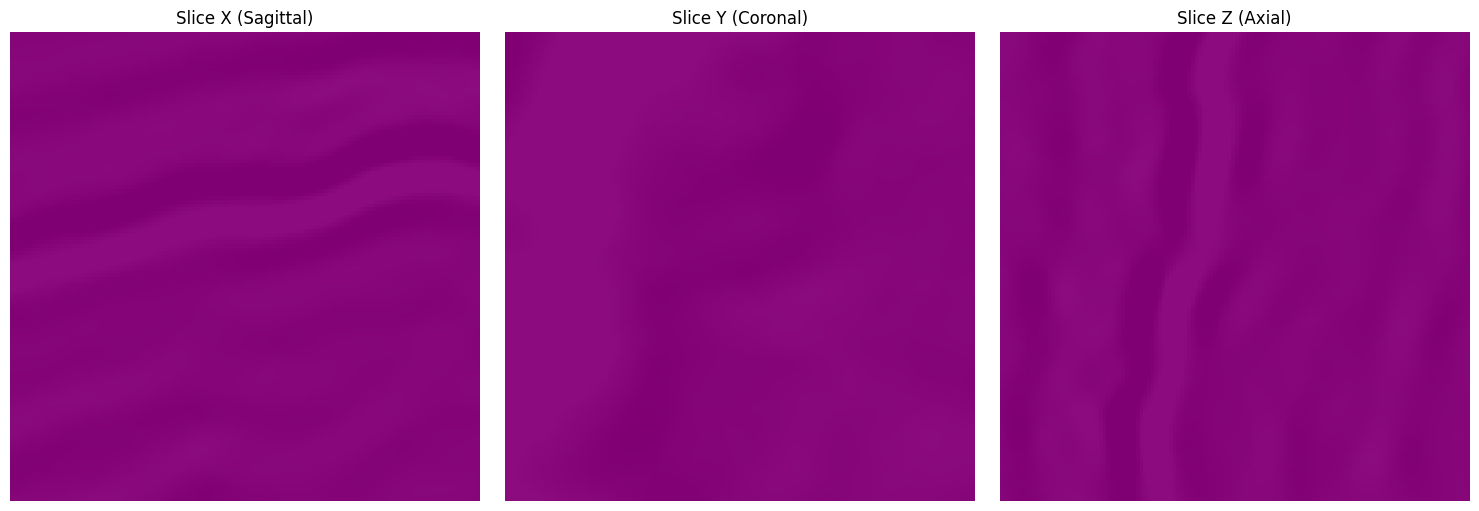

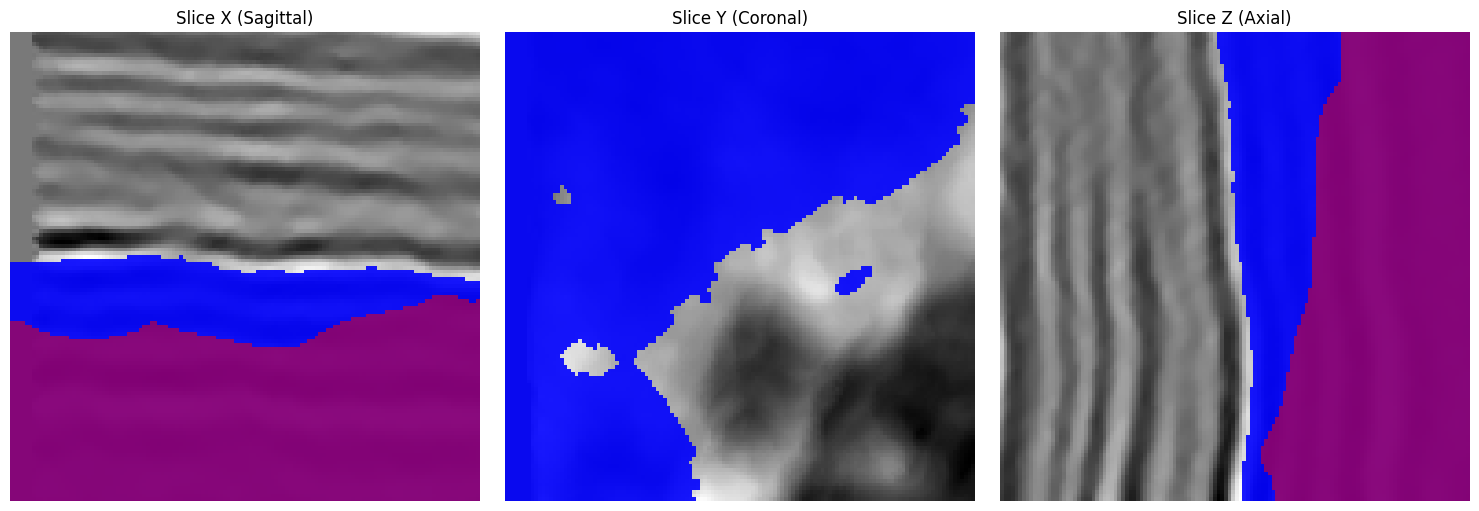

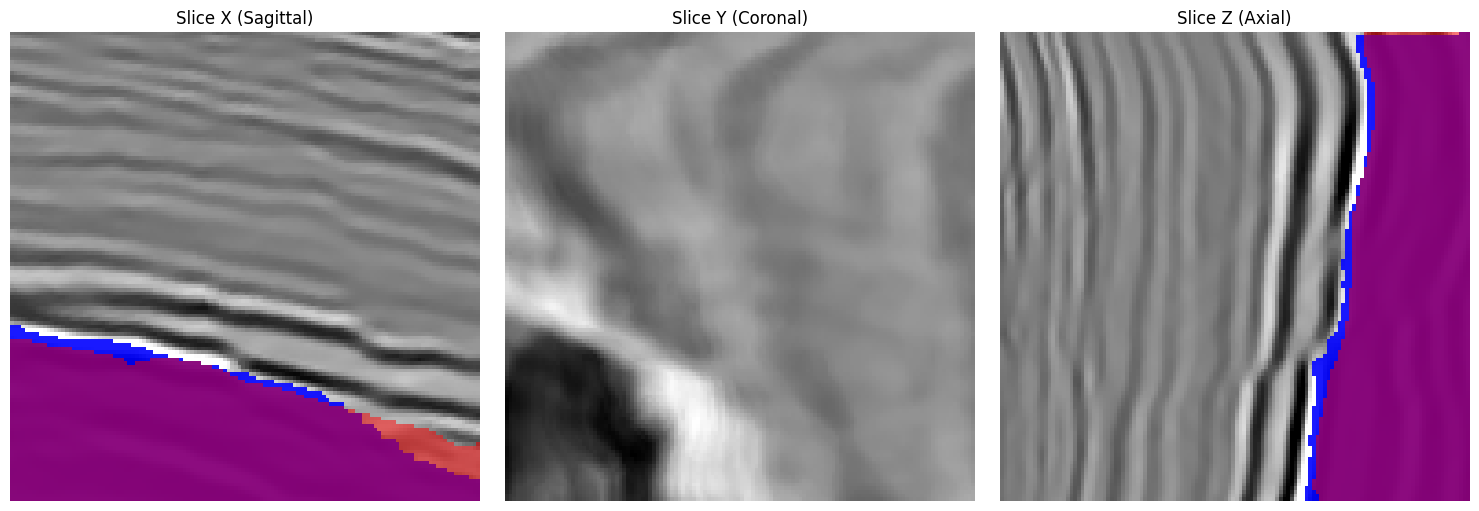

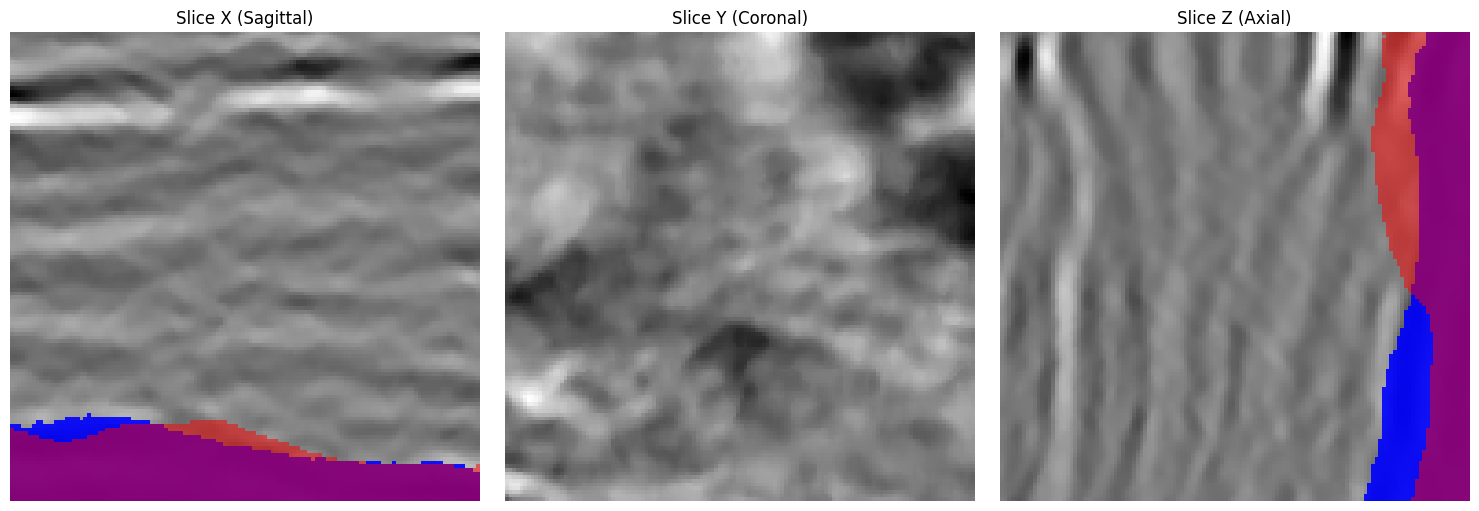

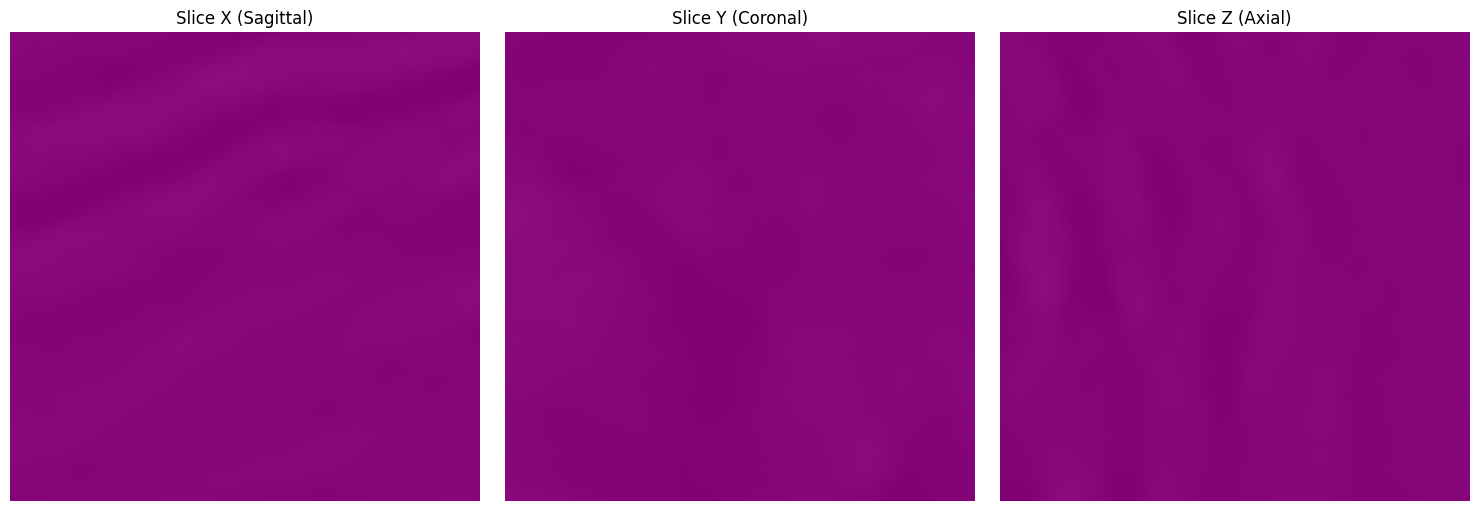

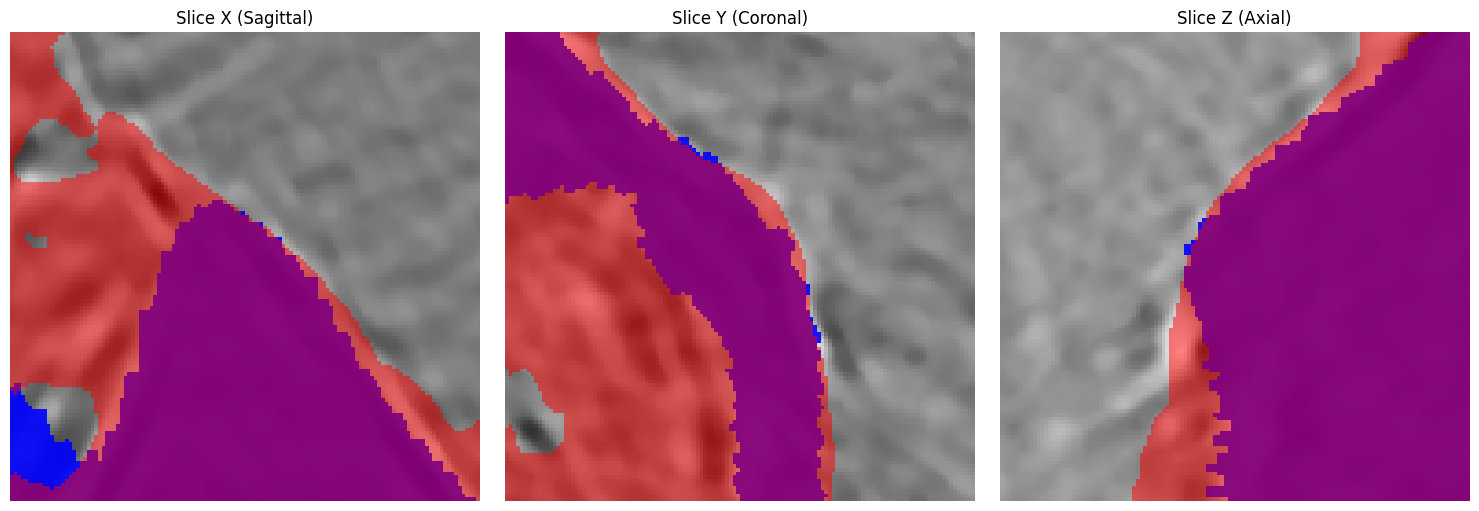

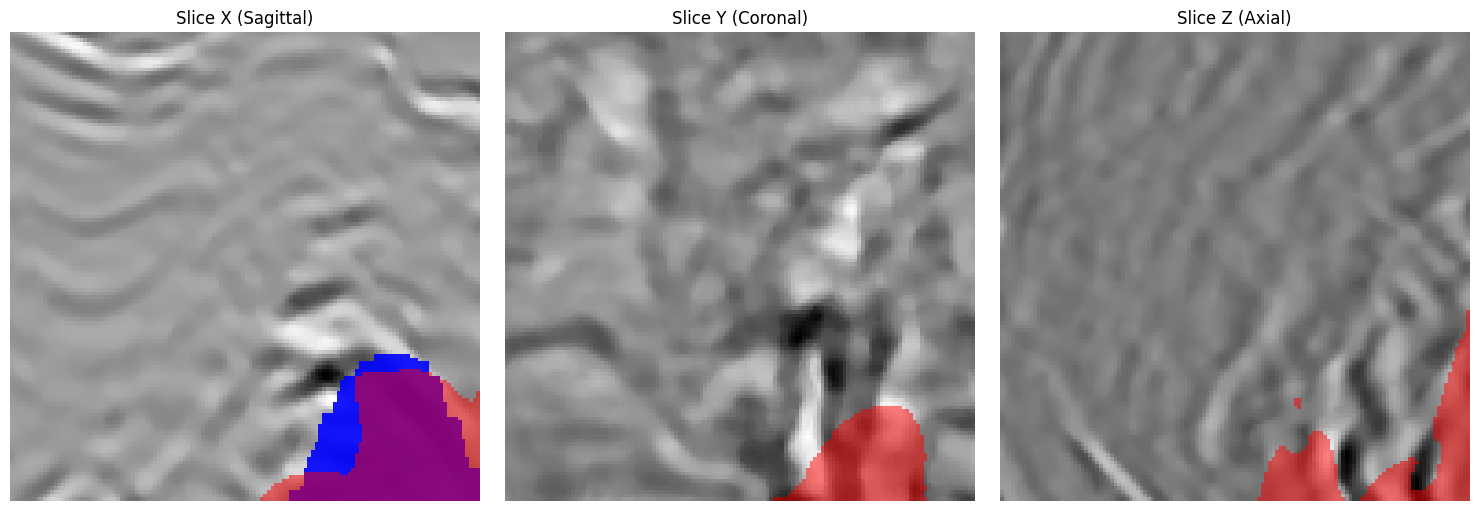

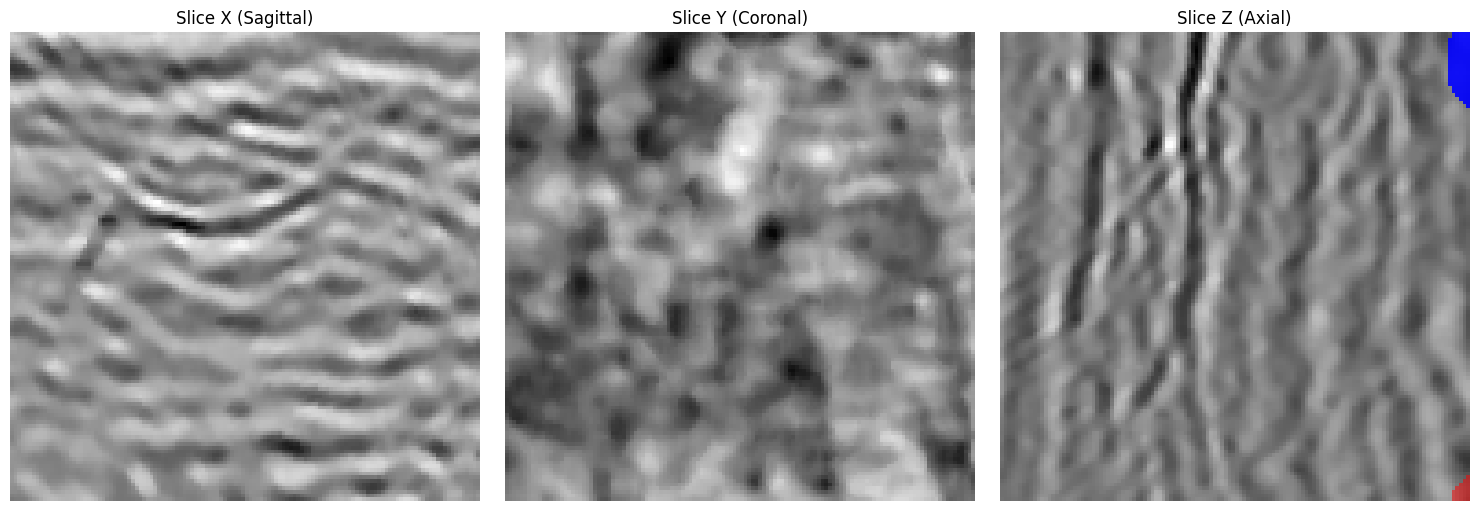

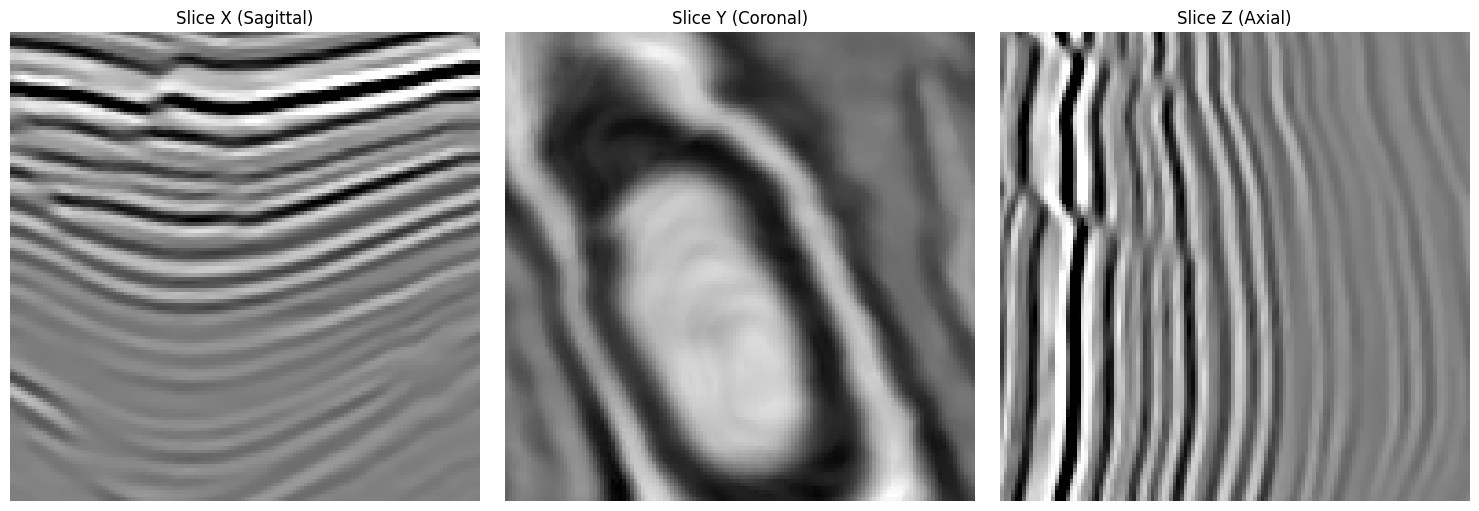

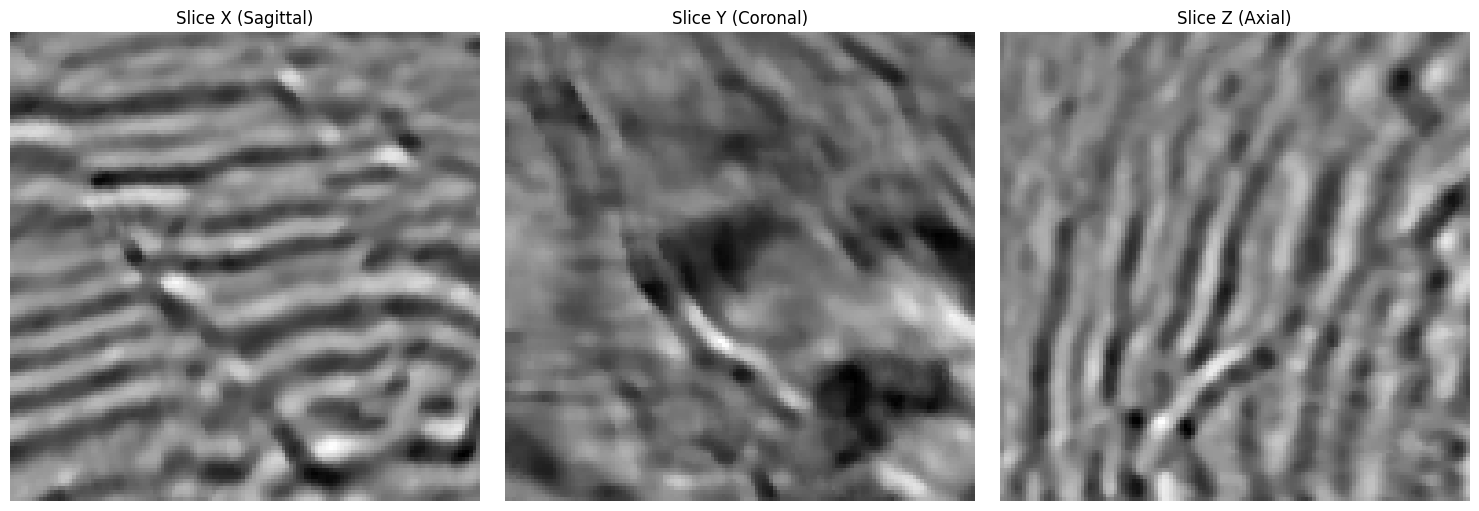

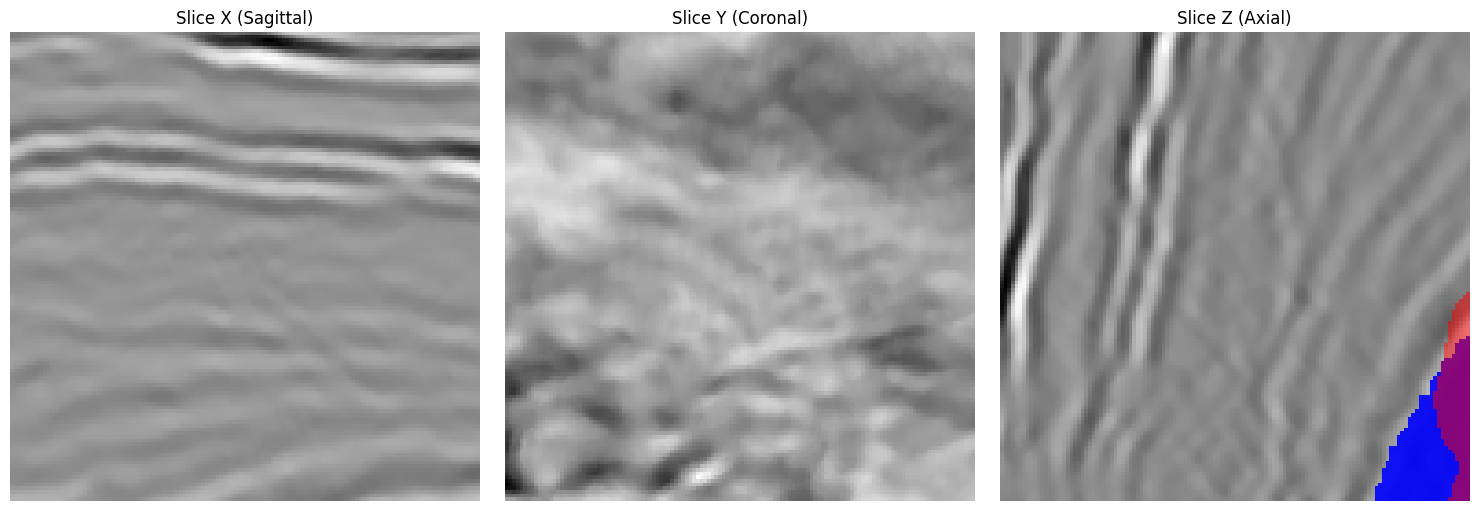

In [120]:
def comparePredictions(img, mask, pred):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    mid = img.shape[0] // 2
    
    slices = [
        (img[mid, :, :], mask[mid, :, :], pred[mid, :, :], 'Slice X (Sagittal)'),
        (img[:, mid, :], mask[:, mid, :], pred[:, mid, :], 'Slice Y (Coronal)'),
        (img[:, :, mid], mask[:, :, mid], pred[:, :, mid], 'Slice Z (Axial)')
    ]

    color_gt   = np.array([0, 0, 255])
    alpha_gt   = 0.9
    
    color_pred = np.array([255, 0, 0])
    alpha_pred = 0.5

    for i, (img_slice, m_gt, m_pred, title) in enumerate(slices):
        img_norm = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        canvas   = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2RGB)
        mask_indices      = (m_gt > 0)
        mask_indices_pred = (m_pred > 0)

        if np.any(mask_indices):
            roi = canvas[mask_indices]
            blended = (roi.astype(float) * (1 - alpha_gt) + color_gt.astype(float) * alpha_gt)
            canvas[mask_indices] = blended.astype(np.uint8)

        if np.any(mask_indices_pred):
            roi = canvas[mask_indices_pred]
            blended = (roi.astype(float) * (1 - alpha_pred) + color_pred.astype(float) * alpha_pred)
            canvas[mask_indices_pred] = blended.astype(np.uint8)

        axes[i].imshow(canvas)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()


os.makedirs(f'{loader.path}/predictions', exist_ok=True)
for i in range(min(len(xTest), 20)):
    p_mask = (yModel[i] > 0.5 )
    comparePredictions(xTest[i], yTest[i], p_mask)
    plt.savefig(f'{loader.path}/predictions/pred_{i}.png')
    plt.show()